In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [35]:
plt.style.use('ggplot')

In [36]:
df = pd.read_csv('https://raw.githubusercontent.com/yonghyeun/Dementia_Analysis/main/data/activity.csv')

In [37]:
df.head()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,activity_score,activity_score_meet_daily_targets,activity_score_move_every_hour,activity_score_recovery_time,activity_score_stay_active,activity_score_training_frequency,activity_score_training_volume,activity_steps,activity_total,target
0,1.262897,202.571429,2208.333333,3659.730159,0.793651,615.142857,0.809524,146.428571,18.333333,5.984127,...,58.682540,18.793651,92.492063,99.698413,66.269841,21.682540,53.031746,4518.460317,165.555556,MCI
1,1.370299,217.477876,1773.504425,5084.876106,0.256637,574.619469,0.539823,281.300885,15.398230,1.778761,...,54.522124,11.601770,95.566372,96.203540,72.088496,6.371681,46.530973,6431.831858,296.955752,CN
2,1.390625,259.672414,2365.137931,3877.741379,0.637931,632.482759,0.362069,328.827586,9.068966,4.379310,...,65.758621,54.068966,97.155172,99.862069,64.965517,16.982759,41.637931,5868.758621,338.534483,MCI
3,1.442555,401.382353,2503.882353,7250.514706,0.382353,534.470588,0.176471,343.852941,30.970588,3.382353,...,91.264706,92.147059,99.117647,98.235294,76.750000,83.750000,93.058824,9444.338235,375.205882,MCI
4,1.388393,271.685714,2114.342857,5053.200000,2.057143,484.085714,0.285714,326.485714,28.285714,8.971429,...,79.000000,72.542857,98.571429,99.885714,83.142857,43.628571,62.342857,7211.600000,356.828571,CN


# 데이터 시각화 

* 민기님 채워주십숑

In [38]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [39]:
X = df.drop('target',axis = 1)
Y = df['target']

In [40]:
enc = LabelEncoder()
label_Y = enc.fit_transform(Y) # 문자형 변수 레이블링

Y = pd.DataFrame(tf.one_hot(label_Y,
                        depth = 3))

In [41]:
def scaling(col):
    
    col_min = np.min(col)
    col_max = np.max(col)
    
    return (col - col_min) / (col_max - col_min)

In [42]:
for col in X.columns:
    
    X[col] = scaling(X[col]) # 수치 안정화를 위해 min_max_scaling

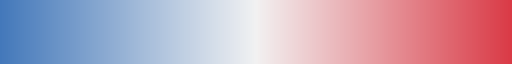

In [43]:
cmap = sns.diverging_palette(250, 10,as_cmap = True) 

cmap

In [44]:
bounds = np.array([-1.0, -0.8, -0.6, -0.4, 0.4, 0.6, 0.8, 1.0]) # 원하는 색상 경계 설정

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

<AxesSubplot:>

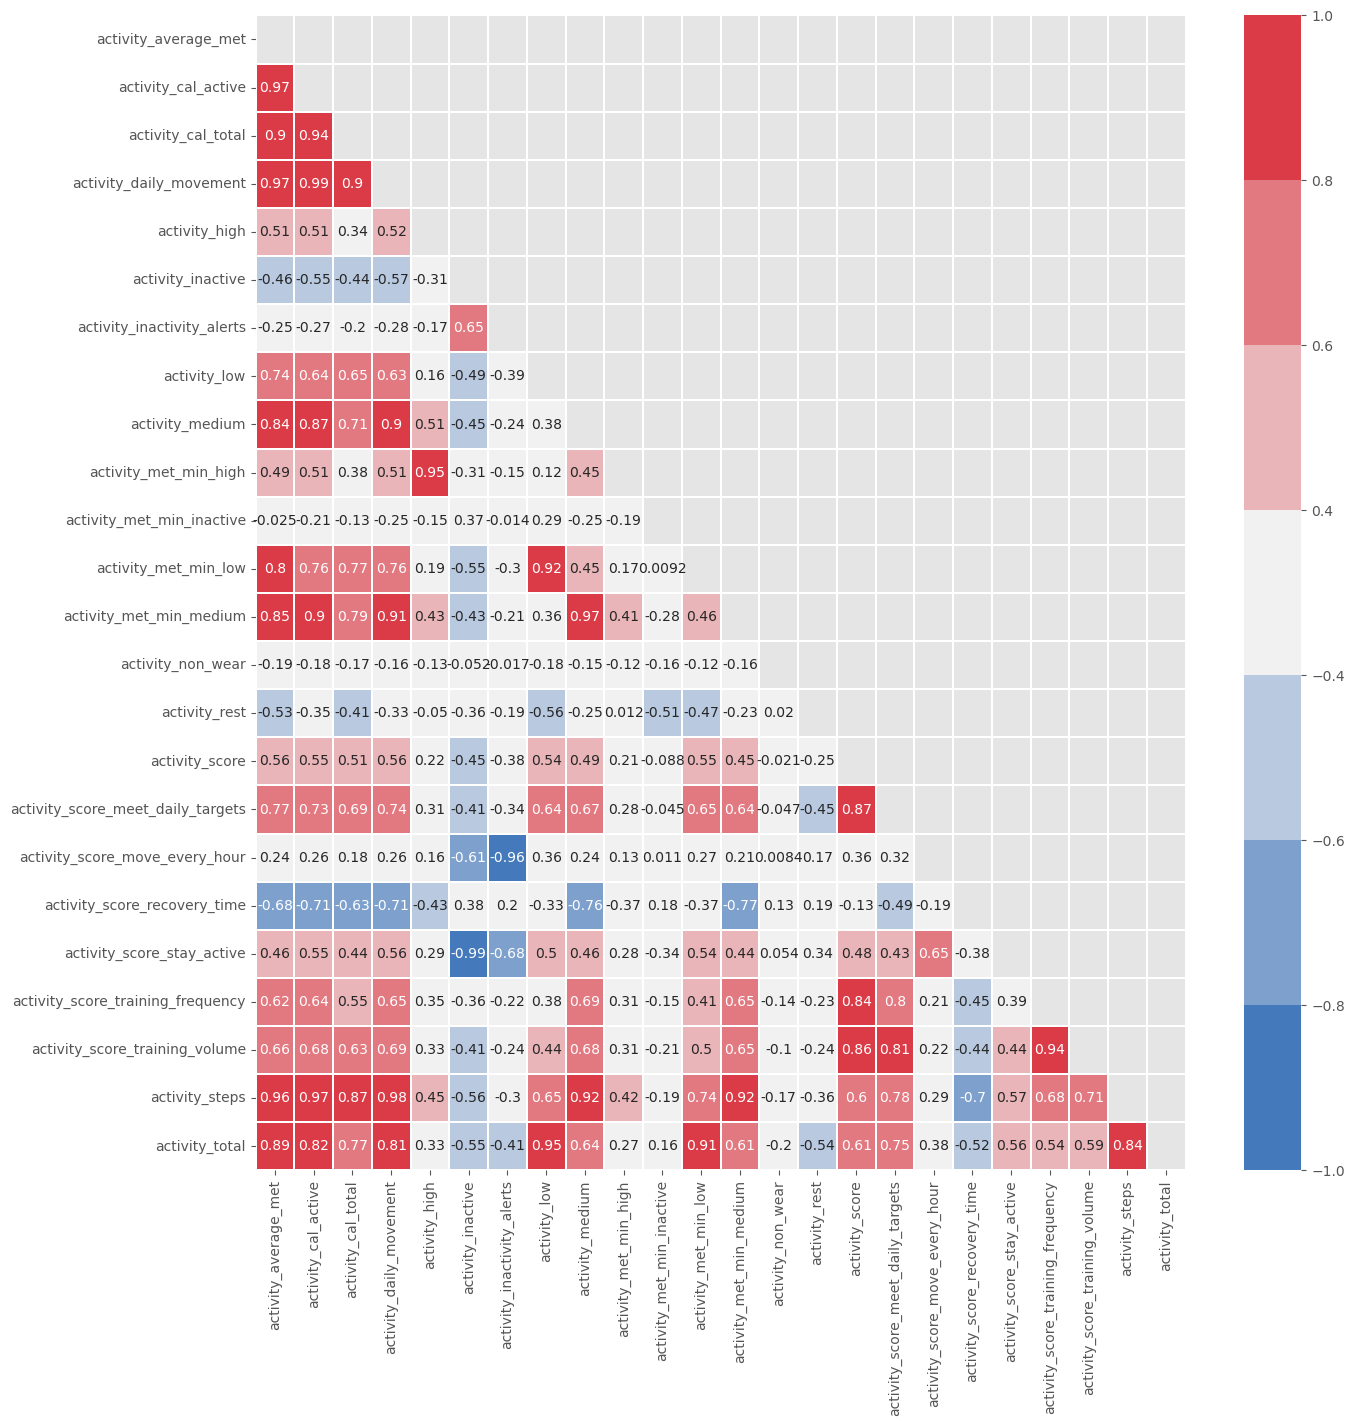

In [45]:
mask = np.triu(np.ones_like(X.corr()))

plt.figure(figsize = (15,15))

sns.heatmap(X.corr(), mask = mask , annot = True, cmap = cmap, norm = norm,
            linewidths = 0.1, fmt = '.2g')

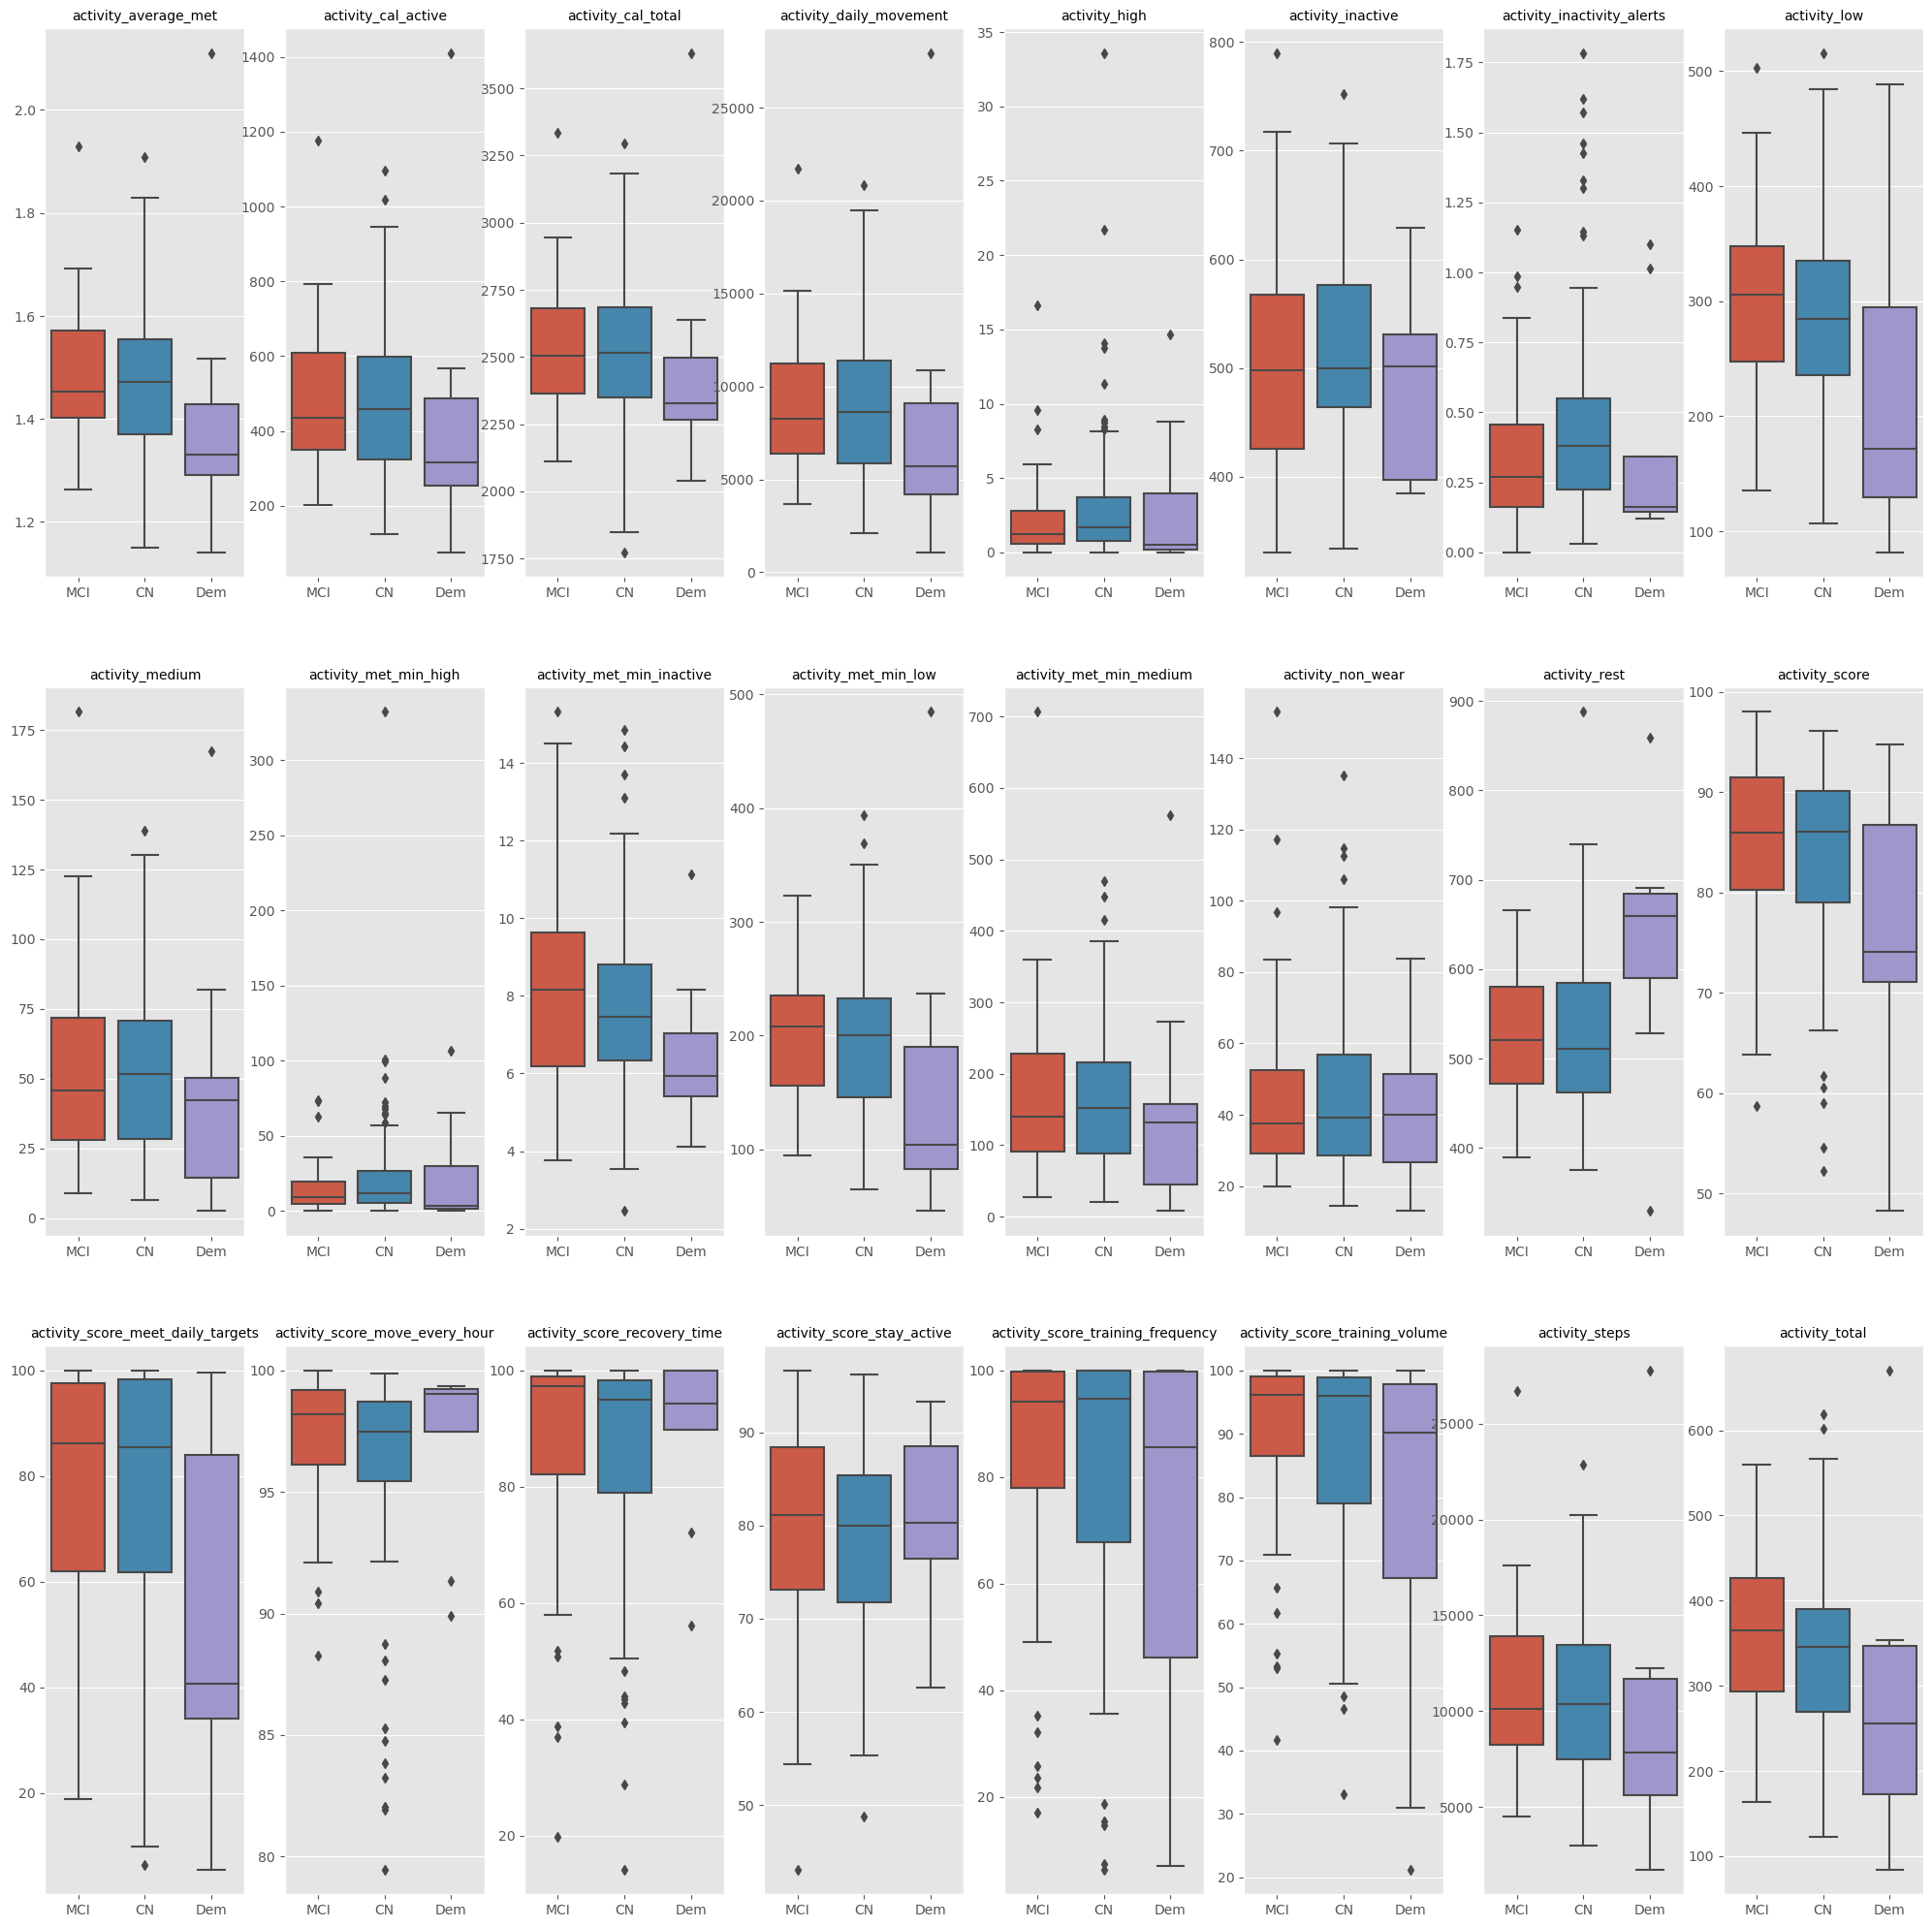

In [46]:
cols = df.columns.tolist()[:-1]

fig,ax = plt.subplots(ncols = 8,nrows=3, 
                        figsize = (25,25))

ax = ax.flatten()

for i,col in enumerate(cols):
    
    sns.boxplot(data = df,
                x = 'target',
                y = col,
                ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(col, fontsize = 10)

* 차원 축소 후 데이터의 패턴을 보자 

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

components = pca.fit_transform(X)

In [48]:
df['target'].unique()

target_colors = {'MCI':'orange','Dem':'red','CN':'green'}

color = df['target'].map(target_colors)

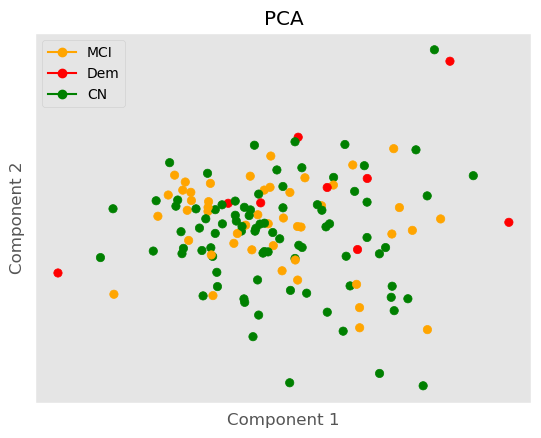

In [49]:
plt.scatter(components[:,0],
            components[:,1],
            color = color)

plt.xticks([])
plt.yticks([])
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label) 
                   for label, color in target_colors.items()]

plt.legend(handles=legend_elements)

* 모든 변수를 가지고 차원 축소를 시행하니 비 치매환자, 경도 인지 장애, 치매 환자 간의 특성의 차이가 유의미하게 보이지 않았다.

* 아노바 테스트를 통해 그룹간의 차이가 유의미한 변수들을 찾아보자 

In [50]:
from sklearn.feature_selection import SelectKBest, f_classif

k = 5 # F-static이 가장 높은 K 개의 변수만 선택하겠다.
selector = SelectKBest(score_func=f_classif, k=k) # ANOVA test
X_new = selector.fit_transform(X, df['target']) # (독립변수 , 종속변수)

mask = selector.get_support() # Feature 들 중 F static 이 높은 상위 K 개만 True로 반출
selected_features = X.columns[mask] # Feature list 중 True 인 변수들만 선택 

print('mask : ', mask) 
print('\n')
print('selected_features : ', selected_features)

mask :  [False False False False False False False  True False False False False
 False False  True  True  True False False False False False False  True]


selected_features :  Index(['activity_low', 'activity_rest', 'activity_score',
       'activity_score_meet_daily_targets', 'activity_total'],
      dtype='object')


In [51]:
anova_test = pd.DataFrame({'Feature':X.columns,  
                            'F-static':selector.scores_,
                            'P-value':selector.pvalues_,}).sort_values(by = 'F-static',
                                                                        ascending = False).reset_index(drop = True)

anova_test # Anova test 결과

,Feature,F-static,P-value
0,activity_rest,5.741660,0.004025
1,activity_score_meet_daily_targets,5.343229,0.005820
2,activity_score,3.283238,0.040457
3,activity_low,3.255877,0.041528
4,activity_total,2.325390,0.101564
5,activity_score_training_volume,2.096684,0.126760
6,activity_inactivity_alerts,2.067916,0.130350
7,activity_score_move_every_hour,1.974946,0.142671
8,activity_met_min_inactive,1.617783,0.202077
9,activity_met_min_low,1.297965,0.276400


* 아노바 테스트를 통해 그룹간 차이가 가장 유의미한 변수 5개만 골라 차원 축소 후 데이터를 살펴보았지만 비 치매군과 치매 군의 유의미한 데이터 패턴을 찾지 못하겠다.

# 모델링

In [69]:
from tensorflow.keras.utils import plot_model

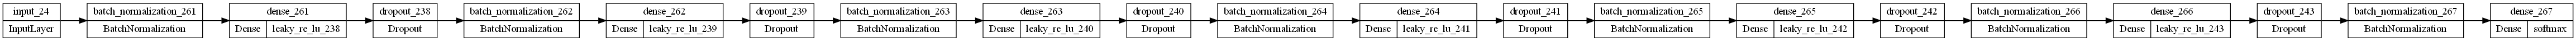

In [74]:
plot_model(model, rankdir = 'LR',
            show_layer_activations=True)

In [75]:
model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 5)]               0         
                                                                 
 batch_normalization_261 (Ba  (None, 5)                20        
 tchNormalization)                                               
                                                                 
 dense_261 (Dense)           (None, 128)               768       
                                                                 
 dropout_238 (Dropout)       (None, 128)               0         
                                                                 
 batch_normalization_262 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dense_262 (Dense)           (None, 32)                412

In [53]:
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import callbacks

* target 데이터의 불균형이 심하니 학습할 때는 오버샘플링을 시행하도록 하자 

In [54]:
def over_sampling(train,target, k):
    
    sampling = SMOTE(k_neighbors = k)
    
    over_train_x, over_train_y = sampling.fit_resample(train,target)
    
    return over_train_x,over_train_y

In [55]:
def one_hot_encoder(target):
    
    enc = LabelEncoder()
    
    target = enc.fit_transform(target)
    
    target = tf.one_hot(target,depth = 3)
    
    return pd.DataFrame(target)

In [288]:
def create_dnn(INPUT_SHAPE,
                FIRST_NODE,
                ALPHA,
                LAYERS,
                HIDDEN_NODE,
                DROPOUT_RATE):
    
    inputs = layers.Input(shape = INPUT_SHAPE)
    
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(units = FIRST_NODE, activation = layers.LeakyReLU(alpha = ALPHA),
                                kernel_initializer = initializers.HeNormal())(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    
    for _ in range(LAYERS):
        
        x = layers.BatchNormalization()(x)    
        x = layers.Dense(units = HIDDEN_NODE, activation = layers.LeakyReLU(alpha = ALPHA),
                                kernel_initializer = initializers.HeNormal())(x)
        x = layers.Dropout(DROPOUT_RATE)(x)
        
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(3, activation = 'softmax',
                                kernel_initializer = initializers.GlorotNormal())(x)
    
    return keras.Model(inputs,outputs)        

In [289]:
data = df.copy()

# data.loc[data['target'] == 'Dem', 'target'] = 'MCI'

In [270]:
from sklearn.preprocessing import PolynomialFeatures

### 현재까지 해본 시도들 

1. Dementia ==> MCI 로 바꿔 binary 분류해봄 -> 씨알도 안먹힘
2. 그룹간 차이가 유의미한 변수 n 개만 골라서 해봄 -> 안됨
3. 차원 축소 후 시행해봄 -> 안됨 
4. Polynomial Feature 로 변수의 복잡도를 올려봄 -> 안됨
5. loss method를 mean_squared _error 로 변경하고 해보자 

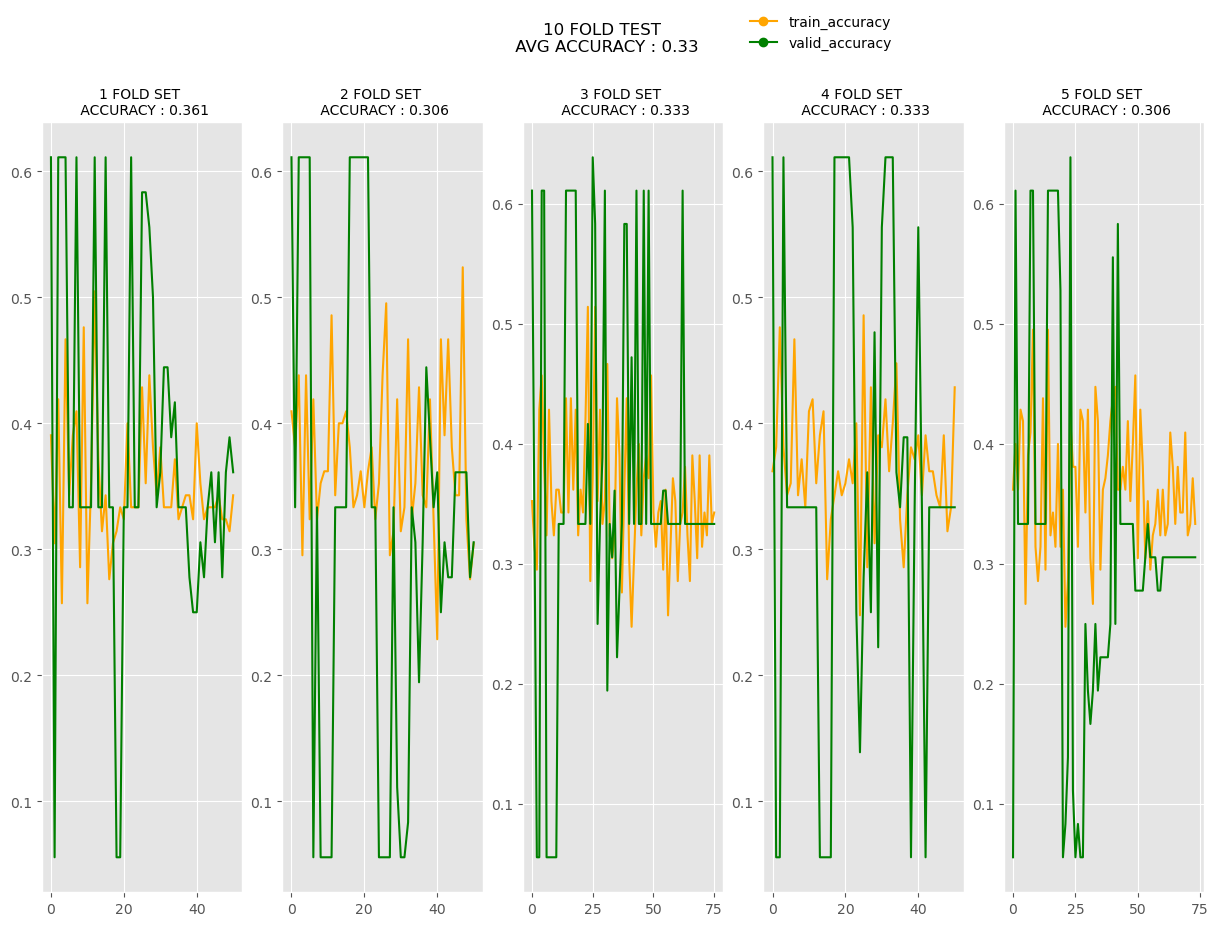

In [438]:
REPEATE = 5

poly = PolynomialFeatures(degree =3, include_bias=False)


X = data[selected_features]

# X = data.drop('target',axis = 1)
# Y = data['target']

X = poly.fit_transform(X) 

params= {'INPUT_SHAPE':X.shape[1:],
        'FIRST_NODE':516,
        'ALPHA':0.01,
        'LAYERS':15,
        'HIDDEN_NODE':256,
        'DROPOUT_RATE':0.3}


optimizers = {'loss': 'categorical_crossentropy',
                'optimizer': tf.optimizers.legacy.Adam(learning_rate=0.1),
                'metrics': ['accuracy']}

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 50)

fig,ax = plt.subplots(ncols = 5, nrows = 1, 
                        figsize = (15,10))
ax = ax.flatten()

    
avg_score = 0    

x_test_list = []
y_test_list = []
model_list = []

# smote = SMOTE(random_state=42)

for i in range(REPEATE):
    
    random_state = 42 + i * 10


    x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state = random_state, stratify = Y)
    
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    enc = LabelEncoder()
    
    # y_train,y_test = enc.fit_transform(y_train), enc.fit_transform(y_test)
    
    y_train , y_test = one_hot_encoder(y_train),one_hot_encoder(y_test)
    
    model = create_dnn(**params)
    model.compile(**optimizers) 
    
    
    history = model.fit(x_train,y_train,
                validation_data = (x_test,y_test),
                epochs = 9999,
                callbacks = [early_stopping],
                verbose = 0,
                class_weight = {0:10,1:30,2:60})

    model_list.append(model)

    score = model.evaluate(x_test,y_test,verbose = 0)[-1]
    
    avg_score += score / REPEATE
    
    ax[i].plot(history.history['accuracy'], c = 'orange',label = 'train_accuracy')
    ax[i].plot(history.history['val_accuracy'], c = 'green',label = 'valid_accuracy')
    
    ax[i].set_title(f'{i + 1} FOLD SET \n ACCURACY : {round(score,3)}', fontsize = 10)
    
    
fig.suptitle(f'10 FOLD TEST \n AVG ACCURACY : {round(avg_score,2)}')


color = ['orange','green']
label = ['train_accuracy','valid_accuracy']
legend_color = {'train_accuracy':'orange','valid_accuracy':'green'}


legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label) 
                    for label, color in legend_color.items()]

fig.legend(handles=legend_elements,
            bbox_to_anchor = (0.7,1),
            frameon = False)


# Loss function 을 보자 

In [442]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [393]:
import warnings

warnings.filterwarnings(action = 'ignore')

# 각 모델의 예측 확률을 살펴보자 

* 실제 MCI,CN 군을 MCI,CN 라고 예측한 확률과 CN 군을 MCI,Dem 라고 예측한 확률이 다를까? 
    * 만약 MCI 군을 MCI 라고 예측한 확률이 CN 군을 MCI 라고 예측한 확률보다 높다면 Threshold를 조정하자 


In [435]:
for i,test in enumerate(y_test_list):
    
    print(i,'번 째 실제값의 분포는 ',dict(test.value_counts()))
    

0 번 째 실제값의 분포는  {'CN': 22, 'MCI': 12, 'Dem': 2}
1 번 째 실제값의 분포는  {'CN': 22, 'MCI': 12, 'Dem': 2}
2 번 째 실제값의 분포는  {'CN': 22, 'MCI': 12, 'Dem': 2}
3 번 째 실제값의 분포는  {'CN': 22, 'MCI': 12, 'Dem': 2}
4 번 째 실제값의 분포는  {'CN': 22, 'MCI': 12, 'Dem': 2}


In [436]:
for num,model in enumerate(model_list): # 각 Fold set 별 예측값을 살펴보기 위한 코드 
    
    
    train = x_test_list[num]
    real = y_test_list[num]
    
    probs = model.predict(train,verbose = 0)
    
    prob_dict = {0:0, 1:0,2:0}
    
    for prob in probs:
        
        prob_dict[np.argmax(prob)] += 1
        
    print(num,'번 째 예측값의 분포는',prob_dict)

0 번 째 예측값의 분포는 {0: 0, 1: 0, 2: 36}
1 번 째 예측값의 분포는 {0: 8, 1: 0, 2: 28}
2 번 째 예측값의 분포는 {0: 0, 1: 0, 2: 36}
3 번 째 예측값의 분포는 {0: 9, 1: 0, 2: 27}
4 번 째 예측값의 분포는 {0: 1, 1: 1, 2: 34}


In [390]:
for num,model in enumerate(model_list): # 각 Fold set 별 예측값을 살펴보기 위한 코드 
    
    
    train = x_test_list[num]
    real = y_test_list[num]
    
    probs = model.predict(train,verbose = 0)
    
    mci_freq = real.value_counts().values[1]
    dem_freq = real.value_counts().values[2]

    correct_prob_dict = {'MCI_prob':0, 'Dem_prob':0}  
    wrong_prob_dict = {'MCI_prob':0, 'Dem_prob':0}
    
    for i,prob in enumerate(probs):
        
        if real.iloc[i] == 'MCI':
            correct_prob_dict['MCI_prob'] += prob[1] / mci_freq
        if real.iloc[i] == 'CN':
            wrong_prob_dict['MCI_prob'] += prob[1] / mci_freq
        if real.iloc[i] == 'Dem':
            correct_prob_dict['Dem_prob'] += prob[2] / dem_freq
        if real.iloc[i] == 'CN':
            wrong_prob_dict['Dem_prob'] += prob[2]/ dem_freq            
            
    print(f'{num} 번 째 실제값의 평균 prob :', correct_prob_dict)        
    print(f'{num} 번 째 오류값의 평균 prob :', wrong_prob_dict)        
    print('\n')
    

0 번 째 실제값의 평균 prob : {'MCI_prob': 0.168637137239178, 'Dem_prob': 0.1536528766155243}
0 번 째 오류값의 평균 prob : {'MCI_prob': 0.24174872836253292, 'Dem_prob': 2.1182075845790678}


1 번 째 실제값의 평균 prob : {'MCI_prob': 0.0009837776160566134, 'Dem_prob': 0.0663129948079586}
1 번 째 오류값의 평균 prob : {'MCI_prob': 0.10165822444832882, 'Dem_prob': 1.754612896591425}


2 번 째 실제값의 평균 prob : {'MCI_prob': 0.044561270624399185, 'Dem_prob': 0.14141039550304413}
2 번 째 오류값의 평균 prob : {'MCI_prob': 0.08168653957545757, 'Dem_prob': 3.11224028468132}


3 번 째 실제값의 평균 prob : {'MCI_prob': 0.35492553422227496, 'Dem_prob': 0.15025964379310608}
3 번 째 오류값의 평균 prob : {'MCI_prob': 0.22256401181221008, 'Dem_prob': 3.051763266324997}


4 번 째 실제값의 평균 prob : {'MCI_prob': 0.030965193795661136, 'Dem_prob': 0.4029616415500641}
4 번 째 오류값의 평균 prob : {'MCI_prob': 0.059142207416395344, 'Dem_prob': 4.775024637579918}


5 번 째 실제값의 평균 prob : {'MCI_prob': 0.027673880259195968, 'Dem_prob': 0.35638758540153503}
5 번 째 오류값의 평균 prob : {'MCI_prob

In [376]:
from sklearn.metrics import confusion_matrix

In [424]:
probs = model_list[0].predict(x_test_list[0])

result = []

for prob in probs:
    
    result.append(np.argmax(prob))

2/2 [==============================] - 0s 10ms/step


Text(0.5, 1.0, 'confusion_matrix')

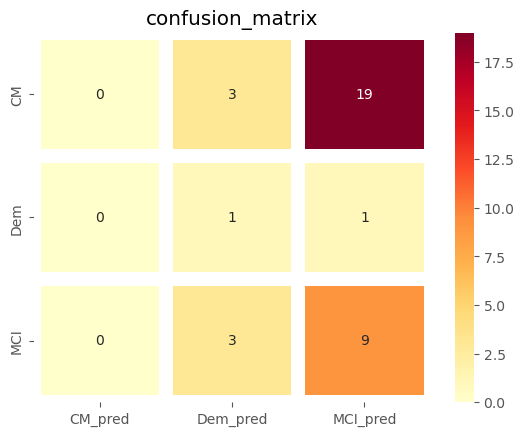

In [437]:
sns.heatmap(pd.DataFrame(confusion_matrix(enc.fit_transform(y_test_list[0]),result),index = ['CM','Dem','MCI'],
                                                                        columns  = ['CM_pred','Dem_pred','MCI_pred']),
            annot = True, cmap = 'YlOrRd', linewidths = 10)
plt.title('confusion_matrix')

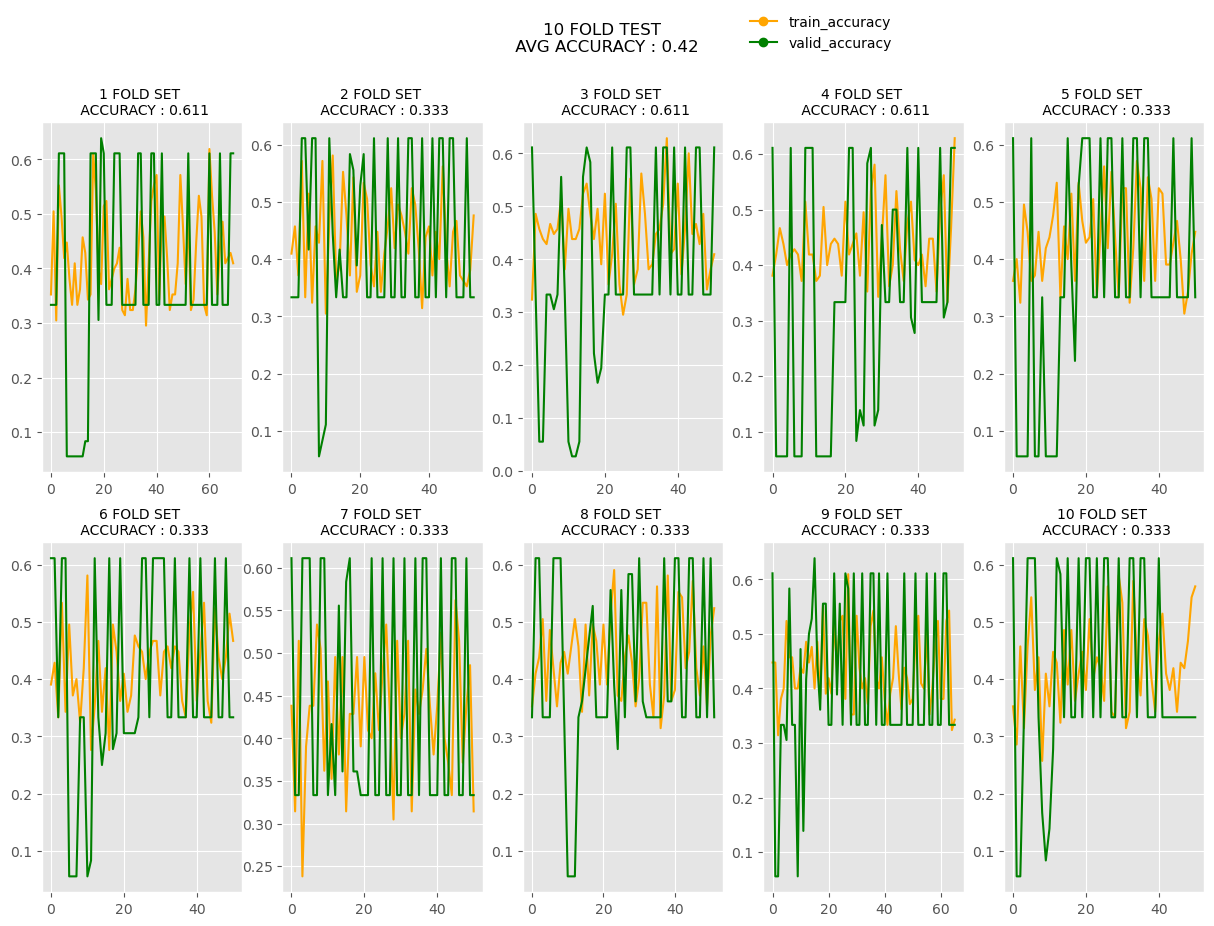

In [361]:
REPEATE = 10

# poly = PolynomialFeatures(degree =3, include_bias=False)


# X = data[selected_features]

X = data.drop('target',axis = 1)
Y = data['target']

# X = poly.fit_transform(X) 

params= {'INPUT_SHAPE':X.shape[1:],
        'FIRST_NODE':128,
        'ALPHA':0.01,
        'LAYERS':10,
        'HIDDEN_NODE':32,
        'DROPOUT_RATE':0.8}


optimizers = {'loss': 'categorical_crossentropy',
                'optimizer': tf.optimizers.legacy.Adam(learning_rate=0.1),
                'metrics': ['accuracy']}

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 50)

fig,ax = plt.subplots(ncols = 5, nrows = 2, 
                        figsize = (15,10))
ax = ax.flatten()

    
avg_score = 0    

x_test_list = []
y_test_list = []
model_list = []

smote = SMOTE(random_state=42)

for i in range(REPEATE):
    
    random_state = 42 + i * 10


    x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state = random_state, stratify = Y)
    
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    enc = LabelEncoder()
    
    # y_train,y_test = enc.fit_transform(y_train), enc.fit_transform(y_test)
    
    y_train , y_test = one_hot_encoder(y_train),one_hot_encoder(y_test)
    
    model = create_dnn(**params)
    model.compile(**optimizers) 
    
    model_list.append(model)
    
    history = model.fit(x_train,y_train,
                validation_data = (x_test,y_test),
                epochs = 9999,
                callbacks = [early_stopping],
                verbose = 0,
                class_weight = {0:20,1:40,2:40})
    
    score = model.evaluate(x_test,y_test,verbose = 0)[-1]
    
    avg_score += score / REPEATE
    
    ax[i].plot(history.history['accuracy'], c = 'orange',label = 'train_accuracy')
    ax[i].plot(history.history['val_accuracy'], c = 'green',label = 'valid_accuracy')
    
    ax[i].set_title(f'{i + 1} FOLD SET \n ACCURACY : {round(score,3)}', fontsize = 10)
    
    
fig.suptitle(f'10 FOLD TEST \n AVG ACCURACY : {round(avg_score,2)}')


color = ['orange','green']
label = ['train_accuracy','valid_accuracy']
legend_color = {'train_accuracy':'orange','valid_accuracy':'green'}


legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label) 
                    for label, color in legend_color.items()]

fig.legend(handles=legend_elements,
            bbox_to_anchor = (0.7,1),
            frameon = False)

In [362]:
for num,model in enumerate(model_list): # 각 Fold set 별 예측값을 살펴보기 위한 코드 
    
    
    train = x_test_list[num]
    real = y_test_list[num]
    
    probs = model.predict(train,verbose = 0)
    
    prob_dict = {0:0, 1:0,2:0}
    
    for prob in probs:
        
        prob_dict[np.argmax(prob)] += 1
        
    print(num,'번 째 예측값의 분포는',prob_dict)

0 번 째 예측값의 분포는 {0: 36, 1: 0, 2: 0}
1 번 째 예측값의 분포는 {0: 0, 1: 0, 2: 36}
2 번 째 예측값의 분포는 {0: 36, 1: 0, 2: 0}
3 번 째 예측값의 분포는 {0: 36, 1: 0, 2: 0}
4 번 째 예측값의 분포는 {0: 0, 1: 0, 2: 36}
5 번 째 예측값의 분포는 {0: 0, 1: 0, 2: 36}
6 번 째 예측값의 분포는 {0: 0, 1: 0, 2: 36}
7 번 째 예측값의 분포는 {0: 0, 1: 0, 2: 36}
8 번 째 예측값의 분포는 {0: 0, 1: 0, 2: 36}
9 번 째 예측값의 분포는 {0: 0, 1: 0, 2: 36}


In [353]:
model.fit(x_train,y_train,
          epochs = 50)

Epoch 1/50
4/4 [==============================] - 2s 6ms/step - loss: 1.5939 - accuracy: 0.4000
Epoch 2/50
4/4 [==============================] - 0s 7ms/step - loss: 2.2920 - accuracy: 0.5238
Epoch 3/50
4/4 [==============================] - 0s 10ms/step - loss: 1.9961 - accuracy: 0.4952
Epoch 4/50
4/4 [==============================] - 0s 7ms/step - loss: 2.1374 - accuracy: 0.4381
Epoch 5/50
4/4 [==============================] - 0s 8ms/step - loss: 2.2505 - accuracy: 0.5048
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 2.8409 - accuracy: 0.4952
Epoch 7/50
4/4 [==============================] - 0s 7ms/step - loss: 2.4584 - accuracy: 0.4857
Epoch 8/50
4/4 [==============================] - 0s 8ms/step - loss: 2.1001 - accuracy: 0.3905
Epoch 9/50
4/4 [==============================] - 0s 8ms/step - loss: 1.8291 - accuracy: 0.5238
Epoch 10/50
4/4 [==============================] - 0s 8ms/step - loss: 1.4416 - accuracy: 0.5143
Epoch 11/50
4/4 [=====================

In [363]:
model.get_weights()

[array([ 1.9898323 ,  2.2134233 ,  6.2382636 ,  5.051231  ,  1.9601445 ,
         5.6939807 ,  2.2527146 ,  1.0753139 , -3.5425725 ,  3.5473282 ,
        -1.2573885 ,  2.8787727 ,  0.439539  ,  2.5472538 ,  3.1304898 ,
        -3.1866057 , -2.6170096 ,  3.2070026 , -1.3842381 ,  2.8693142 ,
         5.533305  ,  3.52766   , -0.22952095,  5.0935616 ], dtype=float32),
 array([ 4.345388  ,  4.432832  ,  0.32026112,  2.0215228 ,  0.5521125 ,
         3.8730597 , -0.47108257,  3.9900284 ,  1.9456574 , -2.04929   ,
        -3.847462  ,  1.4716704 ,  4.450115  , -2.2262368 , -2.052938  ,
        -4.127125  , -3.127116  ,  0.70087194, -3.875055  ,  0.2921744 ,
        -0.6867016 ,  2.0741007 , -3.872867  ,  1.3792894 ], dtype=float32),
 array([1.2859482e+00, 4.1384625e+02, 2.1947476e+03, 7.7844614e+03,
        2.6429324e+00, 4.3883182e+02, 3.4007636e-01, 2.5754700e+02,
        4.5195938e+01, 1.8763966e+01, 6.9958739e+00, 1.7592323e+02,
        1.4360139e+02, 3.8578762e+01, 4.6415289e+02, 7.208

In [185]:
from sklearn.ensemble import RandomForestClassifier

In [257]:
model = RandomForestClassifier(n_estimators = 1000)



In [258]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,stratify= Y)

In [259]:
y_train,y_test = enc.fit_transform(y_train), enc.fit_transform(y_test)

In [260]:
model.fit(x_train,y_train)

RandomForestClassifier(n_estimators=1000)

In [267]:
np.mean(y_test == model.predict(x_test))

0.5277777777777778

In [268]:
model.predict(x_test)

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0])

# 머신러닝으로 풀어보자 

* 차원 축소 시 데이터간의 패턴을 볼 수 있었다.
* PCA 후 KNN 으로 예측력을 높힐 수 있지는 않을까?

In [447]:
X = df.drop('target',axis = 1)
Y = df['target']

In [448]:
def do_pca(data, component):
    
    pca = PCA(n_components = component)
    
    X = data.drop('target',axis = 1)
    Y = data['target']
    
    X = pca.fit_transform(X)
    
    df = pd.DataFrame(X)
    
    df['target'] = Y
    
    return df

In [454]:
df.loc[df['target'] == 'Dem','target'] = 'MCI'

pca_df = do_pca(df,3)

In [466]:
color = {'MCI':'red','CN':'green'}

cmap = pca_df['target'].map(color)

In [482]:
import matplotlib.animation as animation

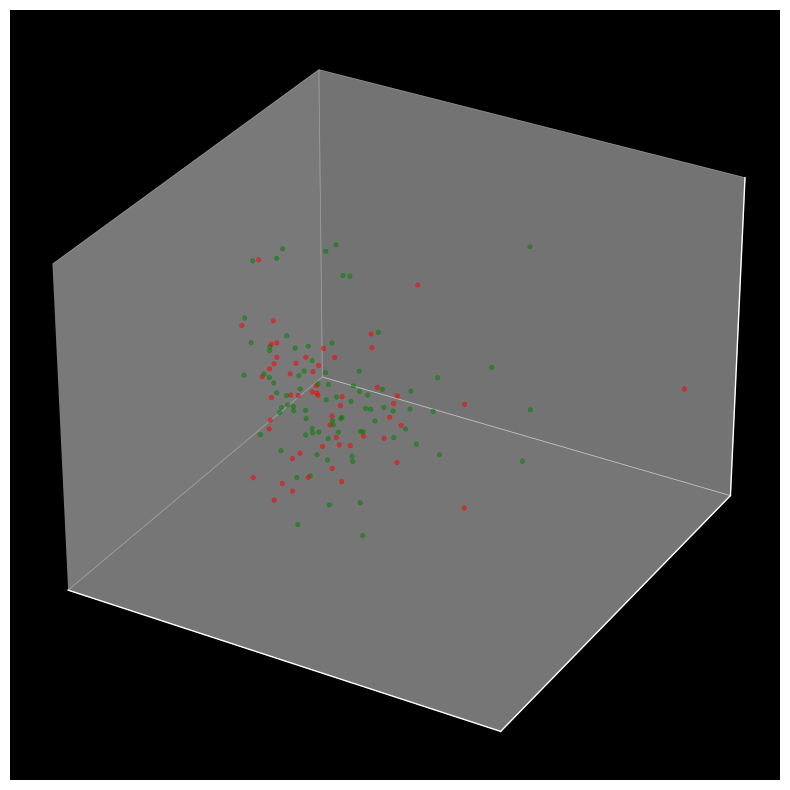

In [530]:
fig,ax = plt.subplots(ncols = 1, subplot_kw = {'projection':'3d'},
                        figsize = (10,10))

ax.scatter(pca_df[0],pca_df[1],pca_df[2], s = 10,
            color = cmap, alpha = 0.5)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_facecolor('black')


* 차원축소를 통해 나타내서 보니 데이터간의 패턴이 조금은 보이는 것만 같다.

In [521]:
def update(i):
    ax.view_init(30, i)
    scatter = ax.scatter(pca_df[0], pca_df[1], pca_df[2], s=100, color=cmap, alpha=0.5)
    return scatter,


In [531]:
from matplotlib.animation import PillowWriter

fps = 10
speed_factor = 0.5  # adjust to control speed
interval = int((1 / fps * 1000 * len(range(0, 360, 5))) / speed_factor / 100)

ani = animation.FuncAnimation(fig, update, frames=range(0, 360, 5), repeat=True, interval=interval)
writer = PillowWriter(fps=fps)
ani.save("spin.gif", writer=writer)

In [532]:
from sklearn.neighbors import KNeighborsClassifier

In [649]:
model = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')

pca_df =do_pca(df,10)

X = pca_df.drop('target',axis  =1)
Y = pca_df['target']


x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,
                                                    stratify = Y)

In [651]:
model.fit(x_train,y_train)

KNeighborsClassifier(weights='distance')

In [652]:
np.mean(y_test == model.predict(x_test))

0.5862068965517241

<AxesSubplot:>

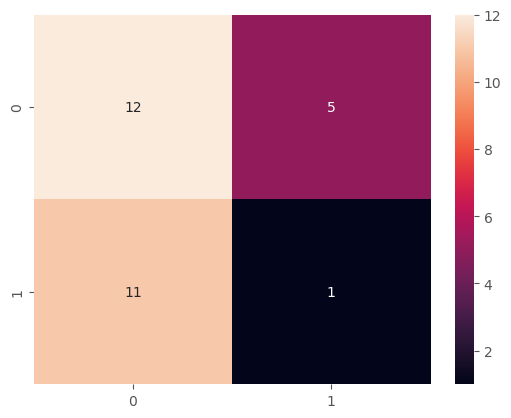

In [618]:
sns.heatmap(confusion_matrix(y_test ,model.predict(x_test)),annot = True)